In [50]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json
import time
import numpy as np

## Dataset Subset Provided in COMPASS GitHub

In [5]:
tcga_train_sample = pd.read_csv('../example/data/tcga_example_train.tsv', sep='\t', index_col=0)
tcga_test_sample = pd.read_csv('../example/data/tcga_example_test.tsv', sep='\t', index_col=0)

In [6]:
print(f"TCGA Train Subset Shape: {tcga_train_sample.shape}")
print(f"TCGA Test Subset Shape: {tcga_test_sample.shape}")

TCGA Train Subset Shape: (495, 1066)
TCGA Test Subset Shape: (99, 1066)


## Analyzing Downloaded TCGA RNA-Seq Data

### Examining Metadata

In [41]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Load data
METADATA_DIR = '/data/rbg/shared/datasets/TCGA/RNA-Seq/rna_features/data/metadata'
sample_path = os.path.join(METADATA_DIR, 'sample.tsv')

print("Loading sample data...")
sample_df = pd.read_csv(sample_path, sep='\t')

# Basic info
print(f"\n{'='*60}")
print("SAMPLE DATA OVERVIEW")
print(f"{'='*60}")
print(f"Total samples: {len(sample_df)}")
print(f"Number of columns: {len(sample_df.columns)}")

# Show first few rows
print(f"\n{'='*60}")
print("FIRST 5 ROWS")
print(f"{'='*60}")
print(sample_df.head())

# Check for cancer type column - now checking for dots in column names
print(f"\n{'='*60}")
print("CANCER TYPE ANALYSIS")
print(f"{'='*60}")

cancer_col = None
# Check for common column name patterns
possible_cols = ['project.project_id', 'project_id', 'disease_type', 'primary_diagnosis']
for col in possible_cols:
    if col in sample_df.columns:
        cancer_col = col
        break

if cancer_col:
    print(f"Using column: '{cancer_col}'")
    cancer_counts = sample_df[cancer_col].value_counts().sort_values(ascending=False)
    print(f"\nCancer type counts:")
    print(cancer_counts)
    print(f"\nTotal unique cancer types: {len(cancer_counts)}")
else:
    print("Could not find cancer type column")
    print(f"Available columns: {sample_df.columns.tolist()}")

Loading sample data...

SAMPLE DATA OVERVIEW
Total samples: 8596
Number of columns: 39

FIRST 5 ROWS
  project.project_id                         cases.case_id cases.submitter_id  \
0          TCGA-READ  8ad1c98b-5395-477e-87a8-19dff3a59c26       TCGA-AG-A02N   
1          TCGA-READ  8ad1c98b-5395-477e-87a8-19dff3a59c26       TCGA-AG-A02N   
2          TCGA-READ  8ad1c98b-5395-477e-87a8-19dff3a59c26       TCGA-AG-A02N   
3          TCGA-BRCA  15ff4b02-bb69-4d24-8a07-b82f428e428d       TCGA-A7-A3IZ   
4          TCGA-BRCA  15ff4b02-bb69-4d24-8a07-b82f428e428d       TCGA-A7-A3IZ   

  samples.biospecimen_anatomic_site samples.biospecimen_laterality  \
0                               '--                            '--   
1                               '--                            '--   
2                               '--                            '--   
3                               '--                            '--   
4                               '--                           

In [43]:
# Summary statistics
print(f"\n{'='*60}")
print("SUMMARY")
print(f"{'='*60}")
print(f"Total samples: {len(sample_df):,}")
if cancer_col:
    print(f"Unique cancer types: {sample_df[cancer_col].nunique()}")
    print(f"\nCancer types present:")
    for cancer_type in sorted(sample_df[cancer_col].unique()):
        count = len(sample_df[sample_df[cancer_col] == cancer_type])
        print(f"  {cancer_type}: {count:,} samples")


SUMMARY
Total samples: 8,596
Unique cancer types: 5

Cancer types present:
  TCGA-BRCA: 3,388 samples
  TCGA-COAD: 1,482 samples
  TCGA-LUAD: 1,641 samples
  TCGA-LUSC: 1,554 samples
  TCGA-READ: 531 samples


### Examining Samples with Gene Counts

In [8]:
# Read manifest file
manifest_df = pd.read_csv('/data/rbg/shared/datasets/TCGA/RNA-Seq/gdc_manifest.counts.2025-07-08.220617.txt', sep='\t')

# Get file UUIDs
file_uuids = manifest_df['id'].tolist()

In [9]:
len(file_uuids)

3094

In [20]:
def get_sample_metadata(file_uuids, batch_size=50):
    """
    Fetch sample metadata from GDC API in batches.
    """
    
    endpoint = "https://api.gdc.cancer.gov/files"
    
    fields = [
        "file_id",
        "file_name",
        "cases.project.project_id",
        "cases.project.name",
        "cases.samples.sample_type",
        "cases.submitter_id",
        "cases.samples.submitter_id"
    ]
    
    all_results = []
    
    # Process in batches
    for i in range(0, len(file_uuids), batch_size):
        batch = file_uuids[i:i + batch_size]
        print(f"Processing batch {i//batch_size + 1} ({len(batch)} files)...")
        
        params = {
            "filters": json.dumps({
                "op": "in",
                "content": {
                    "field": "file_id",
                    "value": batch
                }
            }),
            "fields": ",".join(fields),
            "format": "JSON",
            "size": len(batch)
        }
        
        try:
            response = requests.get(endpoint, params=params, timeout=30)
            response.raise_for_status()
            data = response.json()
            
            if 'data' in data and 'hits' in data['data']:
                all_results.extend(data['data']['hits'])
            else:
                print(f"Warning: Unexpected response format for batch {i//batch_size + 1}")
                
        except requests.exceptions.RequestException as e:
            print(f"Error processing batch {i//batch_size + 1}: {e}")
            print("Retrying in 5 seconds...")
            time.sleep(5)
            
            try:
                response = requests.get(endpoint, params=params, timeout=60)
                response.raise_for_status()
                data = response.json()
                if 'data' in data and 'hits' in data['data']:
                    all_results.extend(data['data']['hits'])
            except Exception as retry_error:
                print(f"Retry failed for batch {i//batch_size + 1}: {retry_error}")
                continue
        
        # Be nice to the API
        time.sleep(0.5)
    
    return all_results

In [21]:
# Get the metadata
metadata = get_sample_metadata(file_uuids)

Processing batch 1 (50 files)...
Processing batch 2 (50 files)...
Processing batch 3 (50 files)...
Processing batch 4 (50 files)...
Processing batch 5 (50 files)...
Processing batch 6 (50 files)...
Processing batch 7 (50 files)...
Processing batch 8 (50 files)...
Processing batch 9 (50 files)...
Processing batch 10 (50 files)...
Processing batch 11 (50 files)...
Processing batch 12 (50 files)...
Processing batch 13 (50 files)...
Processing batch 14 (50 files)...
Processing batch 15 (50 files)...
Processing batch 16 (50 files)...
Processing batch 17 (50 files)...
Processing batch 18 (50 files)...
Processing batch 19 (50 files)...
Processing batch 20 (50 files)...
Processing batch 21 (50 files)...
Processing batch 22 (50 files)...
Processing batch 23 (50 files)...
Processing batch 24 (50 files)...
Processing batch 25 (50 files)...
Processing batch 26 (50 files)...
Processing batch 27 (50 files)...
Processing batch 28 (50 files)...
Processing batch 29 (50 files)...
Processing batch 30 (50

In [24]:
metadata

[{'id': '3396edba-0d2a-4485-ad0a-5114b38c1abe',
  'cases': [{'submitter_id': 'TCGA-GM-A2DL',
    'project': {'project_id': 'TCGA-BRCA',
     'name': 'Breast Invasive Carcinoma'},
    'samples': [{'submitter_id': 'TCGA-GM-A2DL-01A',
      'sample_type': 'Primary Tumor'}]}],
  'file_name': '2e64abe2-6024-4d28-9e09-560ce2a9fd15.rna_seq.augmented_star_gene_counts.tsv',
  'file_id': '3396edba-0d2a-4485-ad0a-5114b38c1abe'},
 {'id': 'd2e2915c-125e-45c6-b7f3-6a815b3d2859',
  'cases': [{'submitter_id': 'TCGA-AC-A2QI',
    'project': {'project_id': 'TCGA-BRCA',
     'name': 'Breast Invasive Carcinoma'},
    'samples': [{'submitter_id': 'TCGA-AC-A2QI-01A',
      'sample_type': 'Primary Tumor'}]}],
  'file_name': '96a45a70-d4b5-4090-b603-73b7379679d6.rna_seq.augmented_star_gene_counts.tsv',
  'file_id': 'd2e2915c-125e-45c6-b7f3-6a815b3d2859'},
 {'id': 'fb32f0b1-4fb7-43d5-8091-dc13a1f6d9e8',
  'cases': [{'submitter_id': 'TCGA-A8-A06R',
    'project': {'project_id': 'TCGA-BRCA',
     'name': 'Breast

In [44]:
# Parse and organize the results
results = []
for hit in metadata:  # metadata is already the list of hits
    file_id = hit['file_id']
    file_name = hit['file_name']
    
    # Get case information
    if 'cases' not in hit or len(hit['cases']) == 0:
        print(f"Warning: No case information for file {file_id}")
        continue
        
    for case in hit['cases']:
        project_id = case.get('project', {}).get('project_id', 'Unknown')
        project_name = case.get('project', {}).get('name', 'Unknown')
        case_id = case.get('submitter_id', 'Unknown')
        
        # Get sample information
        if 'samples' in case and len(case['samples']) > 0:
            for sample in case['samples']:
                sample_type = sample.get('sample_type', 'Unknown')
                sample_id = sample.get('submitter_id', 'Unknown')
                
                results.append({
                    'file_id': file_id,
                    'file_name': file_name,
                    'project_id': project_id,
                    'project_name': project_name,
                    'case_id': case_id,
                    'sample_id': sample_id,
                    'sample_type': sample_type
                })
        else:
            # Add entry even without sample info
            results.append({
                'file_id': file_id,
                'file_name': file_name,
                'project_id': project_id,
                'project_name': project_name,
                'case_id': case_id,
                'sample_id': 'Unknown',
                'sample_type': 'Unknown'
            })
            
results_df = pd.DataFrame(results)

In [45]:
results_df

,file_id,file_name,project_id,project_name,case_id,sample_id,sample_type
0,3396edba-0d2a-4485-ad0a-5114b38c1abe,2e64abe2-6024-4d28-9e09-560ce2a9fd15.rna_seq.a...,TCGA-BRCA,Breast Invasive Carcinoma,TCGA-GM-A2DL,TCGA-GM-A2DL-01A,Primary Tumor
1,d2e2915c-125e-45c6-b7f3-6a815b3d2859,96a45a70-d4b5-4090-b603-73b7379679d6.rna_seq.a...,TCGA-BRCA,Breast Invasive Carcinoma,TCGA-AC-A2QI,TCGA-AC-A2QI-01A,Primary Tumor
2,fb32f0b1-4fb7-43d5-8091-dc13a1f6d9e8,1d468785-141d-40ca-acb1-d6d85a8c9d7b.rna_seq.a...,TCGA-BRCA,Breast Invasive Carcinoma,TCGA-A8-A06R,TCGA-A8-A06R-01A,Primary Tumor
3,de5e449b-bc57-4836-89e4-73a3ba24abdf,748e4eaa-2b96-4dce-a903-c7df733d7f50.rna_seq.a...,TCGA-BRCA,Breast Invasive Carcinoma,TCGA-EW-A1PD,TCGA-EW-A1PD-01A,Primary Tumor
4,a58e2ae3-a236-4209-8292-70465216cb85,e614fbb4-7574-4704-9525-c0aea4c10fc6.rna_seq.a...,TCGA-BRCA,Breast Invasive Carcinoma,TCGA-AO-A12D,TCGA-AO-A12D-01A,Primary Tumor
...,...,...,...,...,...,...,...
3089,fd94a0ed-37d8-49a5-af96-e2160a9e6096,f8cfabf6-dc25-4141-be6c-817dd439a74b.rna_seq.a...,TCGA-BRCA,Breast Invasive Carcinoma,TCGA-BH-A18P,TCGA-BH-A18P-11A,Solid Tissue Normal
3090,37af19f9-56f9-48ec-97a9-5b0b6e364293,a37efe02-9662-4b90-8251-003ccb96aed4.rna_seq.a...,TCGA-BRCA,Breast Invasive Carcinoma,TCGA-C8-A8HP,TCGA-C8-A8HP-01A,Primary Tumor
3091,03a1a105-4856-4e5c-b537-508bdbda50b5,02bbe1b1-44ff-426b-a40e-47a01bc4cf7d.rna_seq.a...,TCGA-BRCA,Breast Invasive Carcinoma,TCGA-EW-A3U0,TCGA-EW-A3U0-01A,Primary Tumor
3092,5b4ec1fd-516d-4c32-a233-0699e591df1a,4331397f-eaf9-4e43-8fa2-e30ad3643aca.rna_seq.a...,TCGA-BRCA,Breast Invasive Carcinoma,TCGA-D8-A1J9,TCGA-D8-A1J9-01A,Primary Tumor


In [46]:
results_df['project_id'].value_counts()

TCGA-BRCA    1231
TCGA-LUAD     600
TCGA-LUSC     562
TCGA-COAD     524
TCGA-READ     177
Name: project_id, dtype: int64

In [59]:
# Get counts for both datasets
# cancer_counts: original samples (metadata)
# cancer_gene_counts: samples with gene count files
cancer_gene_counts = results_df['project_id'].value_counts()

# Get all unique cancer types from both datasets
all_cancer_types = sorted(set(cancer_counts.index) | set(cancer_gene_counts.index))

# Align both counts to the same cancer types
aligned_metadata = [cancer_counts.get(ct, 0) for ct in all_cancer_types]
aligned_gene = [cancer_gene_counts.get(ct, 0) for ct in all_cancer_types]

# Sort by total counts (metadata + gene) for better visualization
total_counts = [m + g for m, g in zip(aligned_metadata, aligned_gene)]
sorted_indices = np.argsort(total_counts)
all_cancer_types = [all_cancer_types[i] for i in sorted_indices]
aligned_metadata = [aligned_metadata[i] for i in sorted_indices]
aligned_gene = [aligned_gene[i] for i in sorted_indices]

# Remove "TCGA-" prefix from labels
cancer_type_labels = [ct.replace('TCGA-', '') for ct in all_cancer_types]


 Comparison histogram saved as 'tcga_cancer_types_comparison.png'


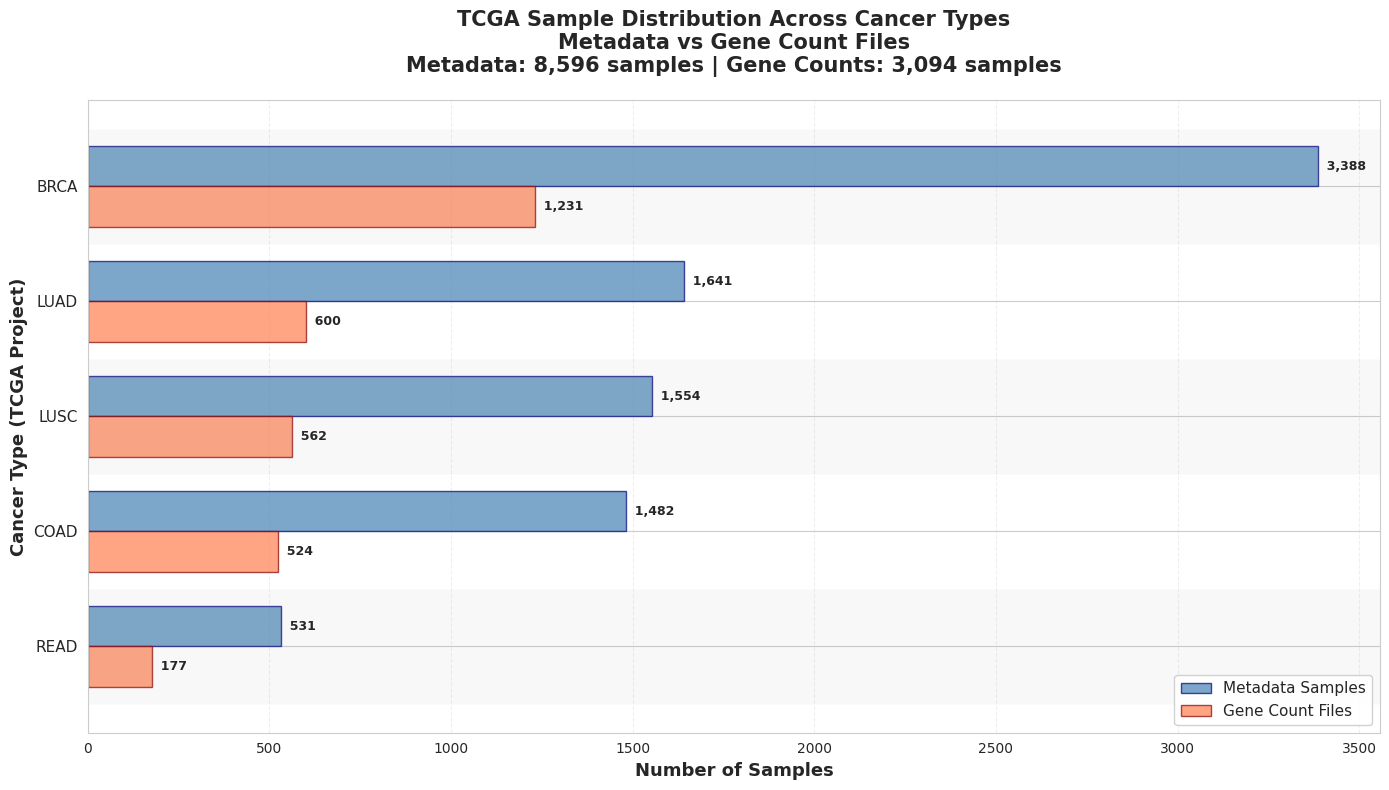

In [61]:
# Create figure
fig, ax = plt.subplots(figsize=(14, max(8, len(all_cancer_types) * 0.5)))

y_pos = np.arange(len(all_cancer_types))
bar_height = 0.35

bars1 = ax.barh(y_pos + bar_height/2, aligned_metadata, bar_height, 
                label='Metadata Samples', color='steelblue', edgecolor='navy', alpha=0.7)
bars2 = ax.barh(y_pos - bar_height/2, aligned_gene, bar_height, 
                label='Gene Count Files', color='coral', edgecolor='darkred', alpha=0.7)

ax.set_yticks(y_pos)
ax.set_yticklabels(cancer_type_labels, fontsize=11)
ax.set_xlabel('Number of Samples', fontsize=13, fontweight='bold')
ax.set_ylabel('Cancer Type (TCGA Project)', fontsize=13, fontweight='bold')
ax.set_title(f'TCGA Sample Distribution Across Cancer Types\nMetadata vs Gene Count Files\n'
             f'Metadata: {sum(aligned_metadata):,} samples | Gene Counts: {sum(aligned_gene):,} samples', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.legend(loc='lower right', fontsize=11, framealpha=0.9)

for i, (metadata_val, gene_val) in enumerate(zip(aligned_metadata, aligned_gene)):
    if metadata_val > 0:
        ax.text(metadata_val, i + bar_height/2, f'  {metadata_val:,}', 
                va='center', fontsize=9, fontweight='bold')
    if gene_val > 0:
        ax.text(gene_val, i - bar_height/2, f'  {gene_val:,}', 
                va='center', fontsize=9, fontweight='bold')

for i in range(0, len(all_cancer_types), 2):
    ax.axhspan(i-0.5, i+0.5, facecolor='gray', alpha=0.05)

plt.tight_layout()
plt.savefig('tcga_cancer_types_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n Comparison histogram saved as 'tcga_cancer_types_comparison.png'")
plt.show()

In [62]:
# Print summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
for ct, ct_label in zip(all_cancer_types, cancer_type_labels):
    metadata = cancer_counts.get(ct, 0)
    gene = cancer_gene_counts.get(ct, 0)
    if metadata > 0 or gene > 0:
        pct = (gene/metadata*100) if metadata > 0 else 0
        print(f"{ct_label:15s} | Metadata: {metadata:4d} | Gene Counts: {gene:4d} | Coverage: {pct:5.1f}%")


SUMMARY STATISTICS
READ            | Metadata:  531 | Gene Counts:  177 | Coverage:  33.3%
COAD            | Metadata: 1482 | Gene Counts:  524 | Coverage:  35.4%
LUSC            | Metadata: 1554 | Gene Counts:  562 | Coverage:  36.2%
LUAD            | Metadata: 1641 | Gene Counts:  600 | Coverage:  36.6%
BRCA            | Metadata: 3388 | Gene Counts: 1231 | Coverage:  36.3%


In [57]:
results_df.to_csv('gene_counts_sample_metadata.csv', index=False)
print("\nMetadata saved to sample_metadata.csv")


Metadata saved to sample_metadata.csv
